### 一.MMEngine可视化总体介绍
MMEngine 引入了可视化对象 Visualizer 和多个可视化存储后端 VisBackend，如 LocalVisBackend、WandbVisBackend 和 TensorboardVisBackend 等。可视化对象 Visualizer 和可视化存储后端 VisBackend 的关系比较好理解：`可视化对象负责绘制过程，而具体的存储交给可视化存储后端。可视化器绘制完成后，可以同时发给多个存储后端。`

为了简化接口调用，大部分情况下用户不会直接操作可视化存储后端，而是由可视化器统一管理。可视化对象 Visualizer 具体功能详细说明如下：

- 支持基础绘图接口以及特征图可视化
- 支持本地， TensorBoard 以及 WandB 等多种后端，可以将训练状态例如 loss 、lr 或者性能评估指标以及可视化的结果写入指定的单一或多个后端
- 支持配置文件存储到多个后端，方便后续复现
- 允许在代码库任意位置调用，对任意位置的特征、图像、状态等进行可视化和存储

#### 功能简介
为了方便不同层级的可视化需求，可视化器 Visualizer 提供了 3 大类 API 接口，分别是：

- 基础绘制接口，典型的如绘制 bbox、mask 和特征图
- OpenMMLab 数据流格式绘制接口 add_datasample，用于支持绘制 MMYOLO 或者其他算法库输出的格式
- 存储接口，将绘制后结果存到后端中

#### 简单案例
- 叠加绘制多个对象
- 绘制内容并存储到多个后端（假设想将绘制的图片保存到本地和 Tensorboard，只需要给 vis_backends 传递多个后端存储对象即可）

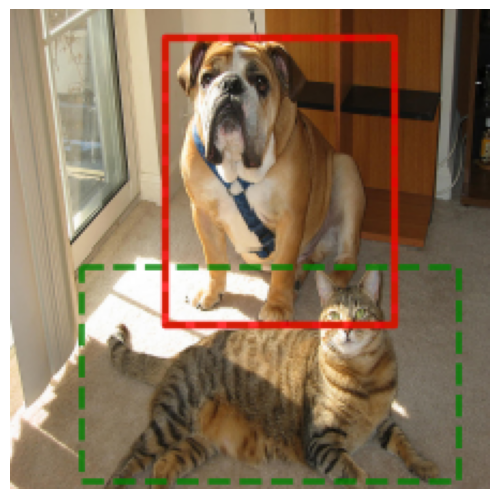

In [7]:
import torch
import mmcv
from mmengine.visualization import Visualizer

# 图片位于 https://github.com/open-mmlab/mmengine/blob/main/docs/en/_static/image/cat_and_dog.png
image = mmcv.imread('cat_and_dog.png', channel_order='rgb')

# 初始化可视化器
visualizer = Visualizer(image=image)

# 绘制多个检测框
visualizer.draw_bboxes(torch.tensor([[33, 120, 209, 220], [72, 13, 179, 147]]), line_styles='--')

# 绘制单个检测框, xyxy 格式
visualizer.draw_bboxes(torch.tensor([72, 13, 179, 147]), edge_colors='r', line_widths=3)

visualizer.show()

In [4]:
import torch
import mmcv
from mmengine.visualization import Visualizer

# 图片位于 https://github.com/open-mmlab/mmengine/blob/main/docs/en/_static/image/cat_and_dog.png
image = mmcv.imread('cat_and_dog.png', channel_order='rgb')

# 初始化可视化器
visualizer = Visualizer(image=image, vis_backends=[dict(type='LocalVisBackend'),dict(type='TensorboardVisBackend')], save_dir='temp_dir')

# 绘制多个检测框
visualizer.draw_bboxes(torch.tensor([[33, 120, 209, 220], [72, 13, 179, 147]]), line_styles='--')

# 将图片存储到多个后端中
visualizer.add_image('demo', visualizer.get_image())

### 二.Dataset输出可视化
Dataset 输出可视化可以快速验证 dataset 和 pipeline 输出是否正确，可谓是一大神器。同时参考 MMClassfication 提供的对每个 pipeline 进行可视化的亮点功能，社区用户也在 MMYOLO 中进行了支持。功能脚本位于 https://github.com/open-mmlab/mmyolo/blob/main/tools/analysis_tools/browse_dataset.py

下面结合 YOLOv5 配置进行详细说明。首先 MMYOLO 中默认的可视化配置为：

In [ ]:
vid_backends = [dict(type='LocalVisBackend')]
visualizer = dict(
    type='mmdet.DetLocalVisualizer',#使用mmdet的可视化器
    vis_backends=vid_backends,
    name='visualizer')

#### 可视化Dataset输出

In [10]:
!cd /data1/shitianlei/openmmlab/mmyolo

/data1/shitianlei/openmmlab/mmyolo


In [ ]:
# 可视化dataset输出结果
!python tools/analysis_tools/browse_dataset.py /data1/shitianlei/openmmlab/mmyolo/configs/custom_dataset/yolov5_s-v61_syncbn_fast_1xb16-100e_midog.py
# 可视化pipeline输出结果
!python tools/analysis_tools/browse_dataset.py /data1/shitianlei/openmmlab/mmyolo/configs/custom_dataset/yolov5_s-v61_syncbn_fast_1xb16-100e_midog.py --mode pipeline

#### 可视化绘制结果保存到WandB
MMEngine 已经支持了常用的 Tensorboard 和 WandB 后端，目前也在不断地新增其他后端。想切换为 WandB 后端，只需要修改配置即可，打开 configs/_base_/default_runtime.py，将 vis_backends 换掉即可：

In [ ]:
vis_backends = [dict(type='WandbVisBackend')]
visualizer = dict(
    type='mmdet.DetLocalVisualizer',
    vis_backends=vis_backends,
    name='visualizer',
    save_dir='result') # 因为这个脚本没有用到 runner，因此必须要指定保存路径

In [ ]:
!python tools/analysis_tools/browse_dataset.py configs/yolov5/yolov5_s-v61_syncbn_8xb16-300e_coco.py --not-show

### 三.模型测试过程可视化
模型测试是通过`test.py`实现。

#### GT和预测分开可视化
只需要指定`--show`即可。也可以指定`--show-dir`将预测结果保存到本地。

In [ ]:
!cd mmyolo 
!python tools/test.py configs/yolov5/yolov5_s-v61_syncbn_fast_8xb16-300e_coco.py yolov5_s-v61_syncbn_fast_8xb16-300e_coco_20220918_084700-86e02187.pth --show

#### GT和预测叠加可视化

MMDetection 中可视化器默认情况下是左右图显示。为何不采用叠加到同一张图显示模式？ 原因是存在 mask 或者其他更密集信息情况下叠加显示效果比较糟糕，在仅仅只有 bbox 标注情况下可能看不出来。

那么如何支持叠加显示？不好意思，在不改代码情况下暂时没有支持，为了能够实现这个需求，下面提供一种改代码的实现方式：

1 打开 mmdet/visualization/local_visualizer.py

2 在 https://github.com/open-mmlab/mmdetection/blob/3.x/mmdet/visualization/local_visualizer.py#L362 前面新增如下代码：

image = gt_img_data
3 在 https://github.com/open-mmlab/mmdetection/blob/3.x/mmdet/visualization/local_visualizer.py#L379 前面新增如下代码：

gt_img_data = None

就可以了。不过为了更好地区分预测框和 GT 框，我们最好需要改一下显示颜色

4 在 https://github.com/open-mmlab/mmdetection/blob/3.x/mmdet/visualization/local_visualizer.py#L133 前面新增如下代码：

colors = (255, 0, 0) if 'scores' in instances else (0, 255, 0)

#### 可视化绘制结果保存到Tensorboard

用户只需要修改配置即可，打开`configs/_base_/default_runtime.py`，将vis_backends换掉，同时还需要修改default_hooks参数

会在 work_dirs/yolov5_s-v61_syncbn_fast_8xb16-300e_coco/时间戳/vis_data 路径下生成 tf 文件，浏览器启动方式为：

tensorboard --logdir work_dirs

In [ ]:
vis_backends = [dict(type='TensorboardVisBackend')]
visualizer = dict(
    type='mmdet.DetLocalVisualizer',
    vis_backends=vis_backends,
    name='visualizer' # 不需要指定保存路径
) 
    
default_hooks = dict(
    visualization= dict(type='mmdet.DetVisualizationHook', 
    interval=1,  # 保存间隔改成 1，每张图片都保存
    draw=True) # 重要！开启绘制和保存功能，默认不开启
) 

#### 可视化NMS前后结果并将结果保存到Tensorboard

为了验证可视化器支持在代码任意位置进行可视化，我们采用 YOLOv5 算法进行测试，并可视化 NMS 前后的效果，并且将对比图保存到 Tensorboard 中。

首先配置文件和第 3 小节一样修改即可，然后在 https://github.com/open-mmlab/mmyolo/blob/main/mmyolo/models/dense_heads/yolov5_head.py#L413 处修改为调用两次_bbox_post_process，其中一次为 nms 前，一次为 nms 后即可。将原先的：

In [ ]:
results = self._bbox_post_process(
        results=results,
        cfg=cfg,
        rescale=False,
        with_nms=with_nms,
        img_meta=img_meta)

In [ ]:
### 替换为如下代码即可：
import mmcv
import numpy as np
from mmengine.visualization import Visualizer
from mmdet.structures import DetDataSample

# 获取可视化器
det_visualizer = Visualizer.get_current_instance()

# 获取原图
img = mmcv.imread(img_meta['img_path'])
img = mmcv.imconvert(img, 'bgr', 'rgb')

# 构建DataSample
pred_data_sample = DetDataSample()

# nms 前结果
results_pre_nms = self._bbox_post_process(
    results=copy.deepcopy(results),
    cfg=cfg,
    rescale=False,
    with_nms=False,
    img_meta=img_meta)
pred_data_sample.pred_instances = results_pre_nms
# 绘制
det_visualizer.add_datasample(
    'nms_or_not',
    img,
    draw_gt=False,
    data_sample=pred_data_sample,
    show=False,
    wait_time=0,
    pred_score_thr=0.3,
    out_file=None)
# 获取 nms 前绘制结果   
img_pre_nms = det_visualizer.get_image()

# nms 后结果
results = self._bbox_post_process(
    results=results,
    cfg=cfg,
    rescale=False,
    with_nms=with_nms,
    img_meta=img_meta)
pred_data_sample.pred_instances = results
# 绘制
det_visualizer.add_datasample(
    'nms_or_not',
    img,
    draw_gt=False,
    data_sample=pred_data_sample,
    show=False,
    wait_time=0,
    pred_score_thr=0.3,
    out_file=None)
# 获取 nms 后绘制结果       
img_post_nms = det_visualizer.get_image()

# 左右图显示
drawn_img = np.concatenate((img_pre_nms, img_post_nms), axis=1)

# 保存到后端
det_visualizer.add_image('pre_and_post_nms_results', drawn_img, step=self._step)
self._step += 1

注意： self._step = 0 需要在 YOLOv5Head 中初始化下。

会在 work_dirs/yolov5_s-v61_syncbn_fast_8xb16-300e_coco/时间戳/vis_data 路径下生成 tensorboard 文件，浏览器启动方式为：
tensorboard --logdir work_dirs

#### 可视化注意力模块并用wandb保存为表格格式

注意力模块添加后是否有效的一个简单检测办法就是可视化注意力前后特征图变化。本小节采用 RTMDet 的骨干网络中通道注意力模块来作为演示案例。

**为了突出可视化器的自定义功能，在绘制后采用wandb特有的表格存储格式进行说明**
